In [11]:
from tcia_utils import nbia
import sys
!{sys.executable} -m pip install --upgrade -q tcia_utils

import requests
import configparser
config = configparser.ConfigParser()
config.read("../config.ini")

from concurrent.futures import ThreadPoolExecutor

import json
import urllib
from io import StringIO

import pydicom
import os
import random
import matplotlib.pyplot as plt

import openslide

import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# 1. CT scans

cart_link = "https://nbia.cancerimagingarchive.net/nbia-search/?saved-cart=nbia-32381737914700927"

In [30]:
# TCGA_collections = [collection for collection in nbia.getCollections() if collection["Collection"].startswith("TCGA")]
# metadata = nbia.getSeries(collection = "TCGA-KIRC")

# data_ct_scans_path = config["datapaths"]["ct_scans_path"]

# cart_id = "nbia-32381737914700927"
# data_CT_scans = nbia.getSharedCart(name = cart_id)
# print(len(data_CT_scans), 'Series returned')

# df = nbia.downloadSeries(data_CT_scans, path=data_ct_scans_path, format = "csv")
# display(df.head())

In [32]:
# download a chunk of series and return metadata
def download_and_collect_metadata(chunk, output_path):
    return nbia.downloadSeries(chunk, path=output_path, format="df")

data_ct_scans_path = config["datapaths"]["ct_scans_path"]
num_threads = 4  # system capacity

data_CT_scans = nbia.getSharedCart(name = "nbia-32381737914700927")
print(len(data_CT_scans), 'Series returned')

#split the data into smaller chunks
chunk_size = len(data_CT_scans) // num_threads
chunks = [data_CT_scans[i:i + chunk_size] for i in range(0, len(data_CT_scans), chunk_size)]

# Parallel downloads and metadata collection
output_path = data_ct_scans_path
dfs = []  # tTo store DataFrames from each chunk

with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = [executor.submit(download_and_collect_metadata, chunk, output_path) for chunk in chunks]
    for future in futures:
        dfs.append(future.result())

# combine all individual DataFrames into one
metadata_ct_scans = pd.concat(dfs, ignore_index=True)
metadata_ct_scans.to_csv(f"{output_path}/metadata_ct_scans.csv", index=False)

2025-01-31 10:27:49,954:INFO:Calling getContentsByName with parameters {'name': 'nbia-32381737914700927'}
2025-01-31 10:27:50,314:INFO:Downloading 5 out of 5 Series Instance UIDs (scans).
2025-01-31 10:27:50,314:INFO:Directory 'D:/data/ct_scans/' already exists.
2025-01-31 10:27:50,314:INFO:Downloading 5 out of 5 Series Instance UIDs (scans).
2025-01-31 10:27:50,314:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.6450.4004.119051745938678655108860595562 already downloaded and unzipped.
2025-01-31 10:27:50,314:INFO:Downloading 5 out of 5 Series Instance UIDs (scans).
2025-01-31 10:27:50,314:INFO:Directory 'D:/data/ct_scans/' already exists.
2025-01-31 10:27:50,314:INFO:Downloading 5 out of 5 Series Instance UIDs (scans).
2025-01-31 10:27:50,330:INFO:Directory 'D:/data/ct_scans/' already exists.
2025-01-31 10:27:50,339:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.6450.4004.235372221968123637436536429205 already downloaded and unzipped.
2025-01-31 10:27:50,339:INFO:Directory 'D:/data/ct_scans/' already 

23 Series returned


2025-01-31 10:27:50,567:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.6450.4004.153715743594716522671526792606 already downloaded and unzipped.
2025-01-31 10:27:50,579:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.6450.4004.400524505778524709531211467468 already downloaded and unzipped.
2025-01-31 10:27:50,599:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.6450.4004.271703816829795254742813110061 already downloaded and unzipped.
2025-01-31 10:27:50,613:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.8421.4004.175115269159141181565296394326 already downloaded and unzipped.
2025-01-31 10:27:50,816:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.6450.4004.526228520181250135810679099250 already downloaded and unzipped.
2025-01-31 10:27:50,816:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.6450.4004.180964259361360923441936969293 already downloaded and unzipped.
2025-01-31 10:27:50,852:WARNING:Series 1.3.6.1.4.1.14519.5.2.1.8421.4004.187310743962446536351224828157 already downloaded and unzipped.
2025-01-31 10:27:50,852:WARNING:Series 1.

- Two subjects
- Subject 1 has 16 series
    - Each series has multiple images
    - Each series may represent different purposes => need to check
- Subject 2 has 7 series
    - Each series has multiple images
    - Each series may represent different purposes => need to check

In [33]:
metadata_ct_scans.head()

,Series UID,Collection,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,...,License URL,Annotation Size,Date Released,Series Date,Protocol Name,Body Part Examined,Annotations Flag,Manufacturer Model Name,Software Versions,TimeStamp
0,1.3.6.1.4.1.14519.5.2.1.6450.4004.119051745938...,TCGA-KIRC,https://doi.org/10.7937/K9/TCIA.2016.V6PBVTDR,TCGA-B0-5085,1.3.6.1.4.1.14519.5.2.1.6450.4004.158131485447...,MRI ABDOMEN WWO CONTR,07-05-1987,ax ssfse,GE MEDICAL SYSTEMS,MR,...,http://creativecommons.org/licenses/by/3.0/,0,Thu Dec 13 11:57:43 UTC 2012,Sun Jul 05 00:00:00 UTC 1987,UPMC RENAL MASS/,KIDNEY,false,SIGNA EXCITE,11,Thu Dec 13 11:57:43 UTC 2012
1,1.3.6.1.4.1.14519.5.2.1.6450.4004.153715743594...,TCGA-KIRC,https://doi.org/10.7937/K9/TCIA.2016.V6PBVTDR,TCGA-B0-5085,1.3.6.1.4.1.14519.5.2.1.6450.4004.158131485447...,MRI ABDOMEN WWO CONTR,07-05-1987,3d fame Special,GE MEDICAL SYSTEMS,MR,...,http://creativecommons.org/licenses/by/3.0/,0,Thu Dec 13 11:58:40 UTC 2012,Sun Jul 05 00:00:00 UTC 1987,UPMC RENAL MASS/,KIDNEY,false,SIGNA EXCITE,11,Thu Dec 13 11:58:40 UTC 2012
2,1.3.6.1.4.1.14519.5.2.1.6450.4004.180964259361...,TCGA-KIRC,https://doi.org/10.7937/K9/TCIA.2016.V6PBVTDR,TCGA-B0-5085,1.3.6.1.4.1.14519.5.2.1.6450.4004.336105265862...,e1 AP,06-18-1987,NaN,GE MEDICAL SYSTEMS,CT,...,http://creativecommons.org/licenses/by/3.0/,0,Thu Dec 13 11:01:13 UTC 2012,Thu Jun 18 00:00:00 UTC 1987,6.13 A/P W/O & W,KIDNEY,false,LightSpeed QX/i,LightSpeedApps10.5_2.8.2I_H1.3M4,Thu Dec 13 11:01:13 UTC 2012
3,1.3.6.1.4.1.14519.5.2.1.6450.4004.181634329297...,TCGA-KIRC,https://doi.org/10.7937/K9/TCIA.2016.V6PBVTDR,TCGA-B0-5085,1.3.6.1.4.1.14519.5.2.1.6450.4004.911144113020...,AP WWO,07-14-1987,NaN,GE MEDICAL SYSTEMS,CT,...,http://creativecommons.org/licenses/by/3.0/,0,Thu Dec 13 11:17:58 UTC 2012,Tue Jul 14 00:00:00 UTC 1987,6.14 KIDNEY MASS,KIDNEY,false,LightSpeed Ultra,LightSpeedApps308I.2_H3.1M5,Thu Dec 13 11:17:58 UTC 2012
4,1.3.6.1.4.1.14519.5.2.1.6450.4004.186509605806...,TCGA-KIRC,https://doi.org/10.7937/K9/TCIA.2016.V6PBVTDR,TCGA-B0-5085,1.3.6.1.4.1.14519.5.2.1.6450.4004.158131485447...,MRI ABDOMEN WWO CONTR,07-05-1987,ax inout phase,GE MEDICAL SYSTEMS,MR,...,http://creativecommons.org/licenses/by/3.0/,0,Thu Dec 13 11:57:55 UTC 2012,Sun Jul 05 00:00:00 UTC 1987,UPMC RENAL MASS/,KIDNEY,false,SIGNA EXCITE,11,Thu Dec 13 11:57:55 UTC 2012


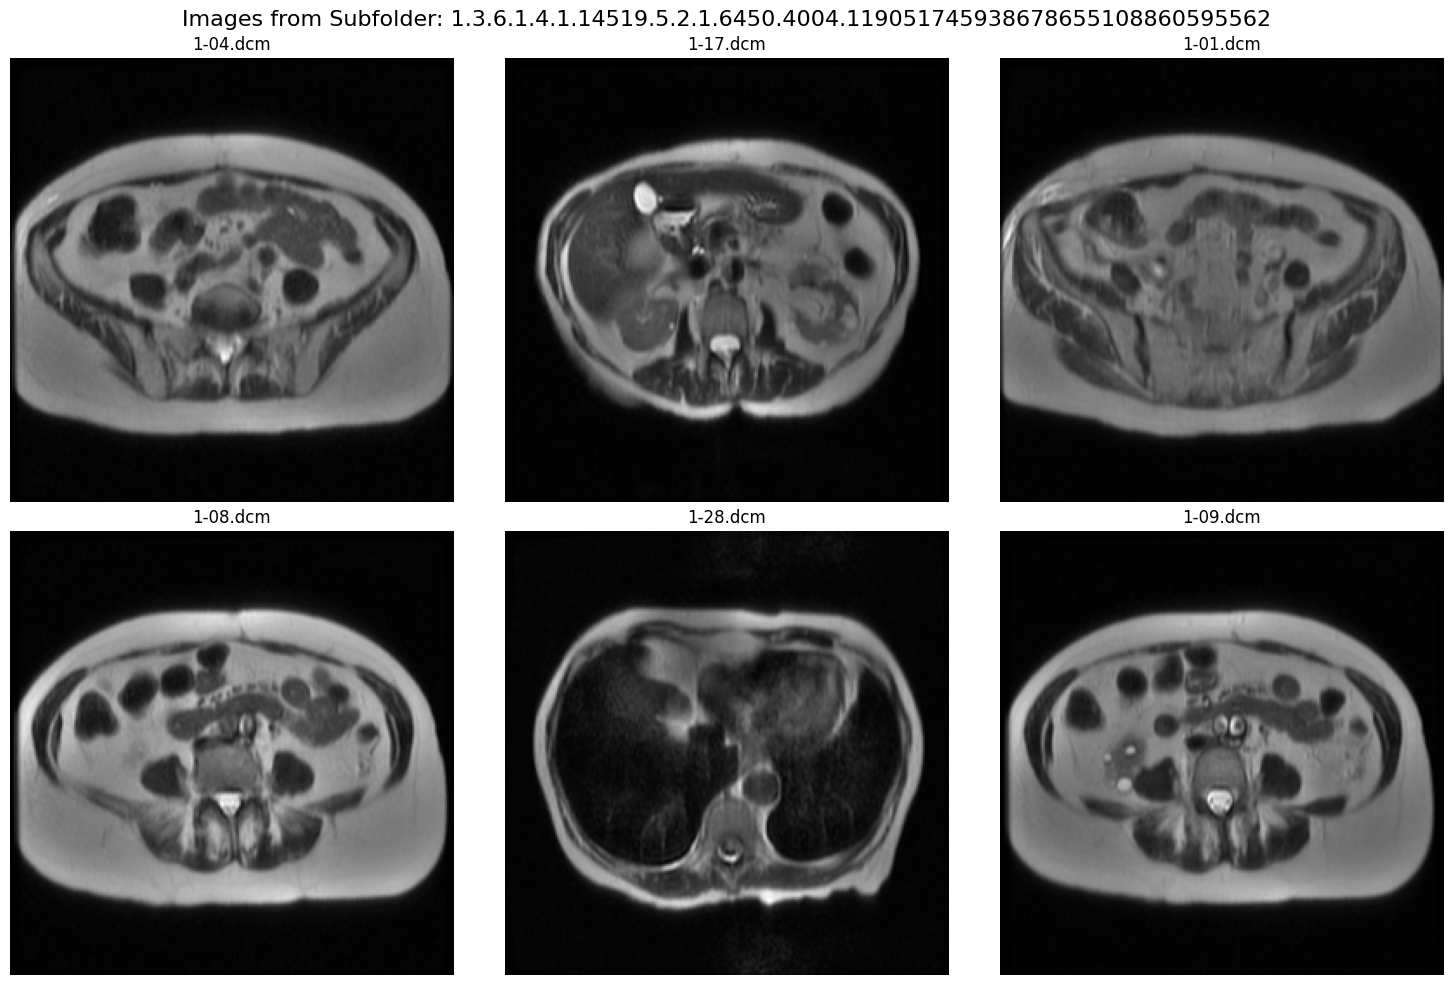

In [21]:
# Define the folder path
folder_path = config["datapaths"]["ct_scans_path"]

def display_dicom_grid(image_paths, subfolder_name):
    """Displays a grid of DICOM images."""
    num_images = len(image_paths)
    cols = 3  # Number of columns in the grid
    rows = (num_images + cols - 1) // cols  # Calculate the required number of rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for i, image_path in enumerate(image_paths):
        dicom_data = pydicom.dcmread(image_path)
        axes[i].imshow(dicom_data.pixel_array, cmap="gray")
        axes[i].axis("off")
        axes[i].set_title(os.path.basename(image_path))
    
    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    
    plt.suptitle(f"Images from Subfolder: {subfolder_name}", fontsize=16)
    plt.tight_layout()
    plt.show()

def process_subfolder(subfolder_path):
    """Processes a subfolder to print DICOM images in a grid."""
    # Get all files in the subfolder
    files = [os.path.join(subfolder_path, f) for f in os.listdir(subfolder_path) if f.endswith('.dcm')]
    
    if not files:
        print(f"No DICOM files in {subfolder_path}.")
        return
    
    # Select 6 random images or all if less than 6
    selected_files = random.sample(files, min(len(files), 6))
    
    # Display the images in a grid
    subfolder_name = os.path.basename(subfolder_path)
    display_dicom_grid(selected_files, subfolder_name)

# Iterate through each subfolder in the main folder
for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    if os.path.isdir(subfolder_path):
        process_subfolder(subfolder_path)
    break


# 2. Clinical

In [26]:
case_ids = ["TCGA-B8-A54E", "TCGA-B0-5085"]

def queryBuilder(endpoint, filters, fields, size, frmat):
    api_url = 'https://api.gdc.cancer.gov/'
    if frmat.lower() == 'json':
        request_query = api_url + endpoint + '?filters=' + filters + '&fields=' + fields + '&size=' + size + '&format=' + frmat + '&pretty=true'
    else:
        request_query = api_url + endpoint + '?filters=' + filters + '&fields=' + fields + '&size=' + size + '&format=' + frmat
    return request_query


def get_raw_clinical():
    combination_two = {
                "op":"=",
                "content":{
                    "field": "cases.project.project_id", 
                    "value": "TCGA-KIRC"
        }
    }

    json_string=str(json.dumps(combination_two))
    filters_format = urllib.parse.quote(json_string.encode('utf-8'))

    #step 2: specify fields to be returned
    fields = ",".join([
        "submitter_id",
        "diagnoses.age_at_diagnosis", # instead of age_at_index
        "demographic.cause_of_death", "demographic.days_to_death",
        "demographic.gender", "demographic.race", "demographic.vital_status",
        "diagnoses.ajcc_pathologic_m", "diagnoses.ajcc_pathologic_n",
        "diagnoses.ajcc_pathologic_stage", "diagnoses.ajcc_pathologic_t", 
        "diagnoses.days_to_last_follow_up", 
        
        # "demographic.ethnicity", # not reported too many
        #"diagnoses.year_of_diagnosis", "demographic.year_of_death", # not relevant, not useful
        # "diagnoses.progression_or_recurrence", 
        # "diagnoses.classification_of_tumor", 'diagnoses.tumor_grade', # no data
    ])

    #step 3+4: specify size=2 and format=tsv, build query url with 'cases' endpoint
    max_observations = '537'
    template = queryBuilder('cases', filters_format, fields, max_observations, "tsv")

    #step 5: send request
    content = requests.get(template)

    data = StringIO(content.text)
    df = pd.read_csv(data, sep="\t")
    output_path = config["clinical_path"]["raw_clinical"]
    df.to_csv(output_path, index=False)

    print("done querying and saving the raw clinical csv file")

get_raw_clinical()

done querying and saving the raw clinical csv file


In [92]:
schema_endpoint = "https://api.gdc.cancer.gov/files/_mapping"
response = requests.get(schema_endpoint)
schema = response.json()
with open("available_fields_for_files.txt", "w") as file:
    file.write("Available fields for files:\n\n")
    for field in schema["fields"]:
        file.write(f"{field}\n")

In [168]:
def clean_metadata_clinical(file_name = config["clinical_path"]["raw_clinical"]):
    """ 
    - creates time and event columns
    - removes unnecessary columns
    - fills missing data for 2 columns (only missing 2 and 3 respectively)
    - renames
    """
    df = pd.read_csv(file_name)
    # create a time and an event feature
    df["time"] = df.apply(
        lambda row: row["demographic.days_to_death"]
        if row["demographic.vital_status"] == "Dead"
        else row["diagnoses.0.days_to_last_follow_up"],
        axis=1,)
    df["time"] = df["time"].astype("uint16") # save memory usage in range 0 to 65535
    df = df.rename(columns={"demographic.vital_status": "event"})
    df["event"] = df["event"].apply(lambda x: 1 if x=="Dead" else 0).astype("int8")
    # remove the other date columns
    df = df.drop(["demographic.days_to_death", "diagnoses.0.days_to_last_follow_up"], axis=1)
    # fill misisng data unknown category ===>> to fill in ordinal code as -1 hmmmm # TODO
    df = df.fillna("unknown")
    # rename cols
    df = df.rename(columns={
        "demographic.gender": "gender",
        "demographic.race": "race",
        "diagnoses.0.age_at_diagnosis": "age_diagnosis",
        "diagnoses.0.ajcc_pathologic_m": "ajcc_m", 
        "diagnoses.0.ajcc_pathologic_n": "ajcc_n",
        "diagnoses.0.ajcc_pathologic_stage": "ajcc_stage",
        "diagnoses.0.ajcc_pathologic_t": "ajcc_t"})
    # convert to integer
    df['age_diagnosis'] = pd.to_numeric(df['age_diagnosis'], errors='coerce') 
    df['age_diagnosis'] = df['age_diagnosis'].fillna(df['age_diagnosis'].mean()).astype(int)
    return df

df = clean_metadata_clinical()
df

,gender,race,event,age_diagnosis,ajcc_m,ajcc_n,ajcc_stage,ajcc_t,id,submitter_id,time
0,female,white,0,22320,M0,N0,Stage I,T1b,fb9bafa5-7133-4955-8156-4eb6763dc8e1,TCGA-B0-5695,2150
1,male,white,0,15360,M0,NX,Stage I,T1a,33cf0893-0411-4758-aa90-602bfedf0850,TCGA-BP-4807,211
2,male,white,0,24850,M0,N0,Stage I,T1b,9245a557-01ea-4446-b9e9-313f6ab18834,TCGA-BP-4995,1371
3,male,white,0,15264,M0,NX,Stage I,T1a,c6454371-1f84-4e8e-8c3a-2eac8380819e,TCGA-DV-5573,1130
4,female,white,1,25508,M1,N1,Stage IV,T4,33cd8b05-2b9b-40dd-97a2-40d02e27ee90,TCGA-CJ-4900,1714
...,...,...,...,...,...,...,...,...,...,...,...
532,female,white,0,17114,M0,N0,Stage I,T1a,4c44f4a4-1529-4897-9f69-c8e6c705f905,TCGA-A3-3385,1993
533,female,white,0,15219,M0,NX,Stage I,T1b,e58f2c7b-d1cc-48f3-a0c9-dcd2b27c37f6,TCGA-B8-5552,1046
534,male,white,0,23477,M0,NX,Stage IV,T4,d7ab7ec0-3de7-4ffd-a5ac-f75579355b2a,TCGA-B0-5402,1290
535,female,asian,1,25013,M0,N0,Stage III,T3b,8d769b38-862f-46e3-a426-d09f79f28de6,TCGA-B0-4821,1230


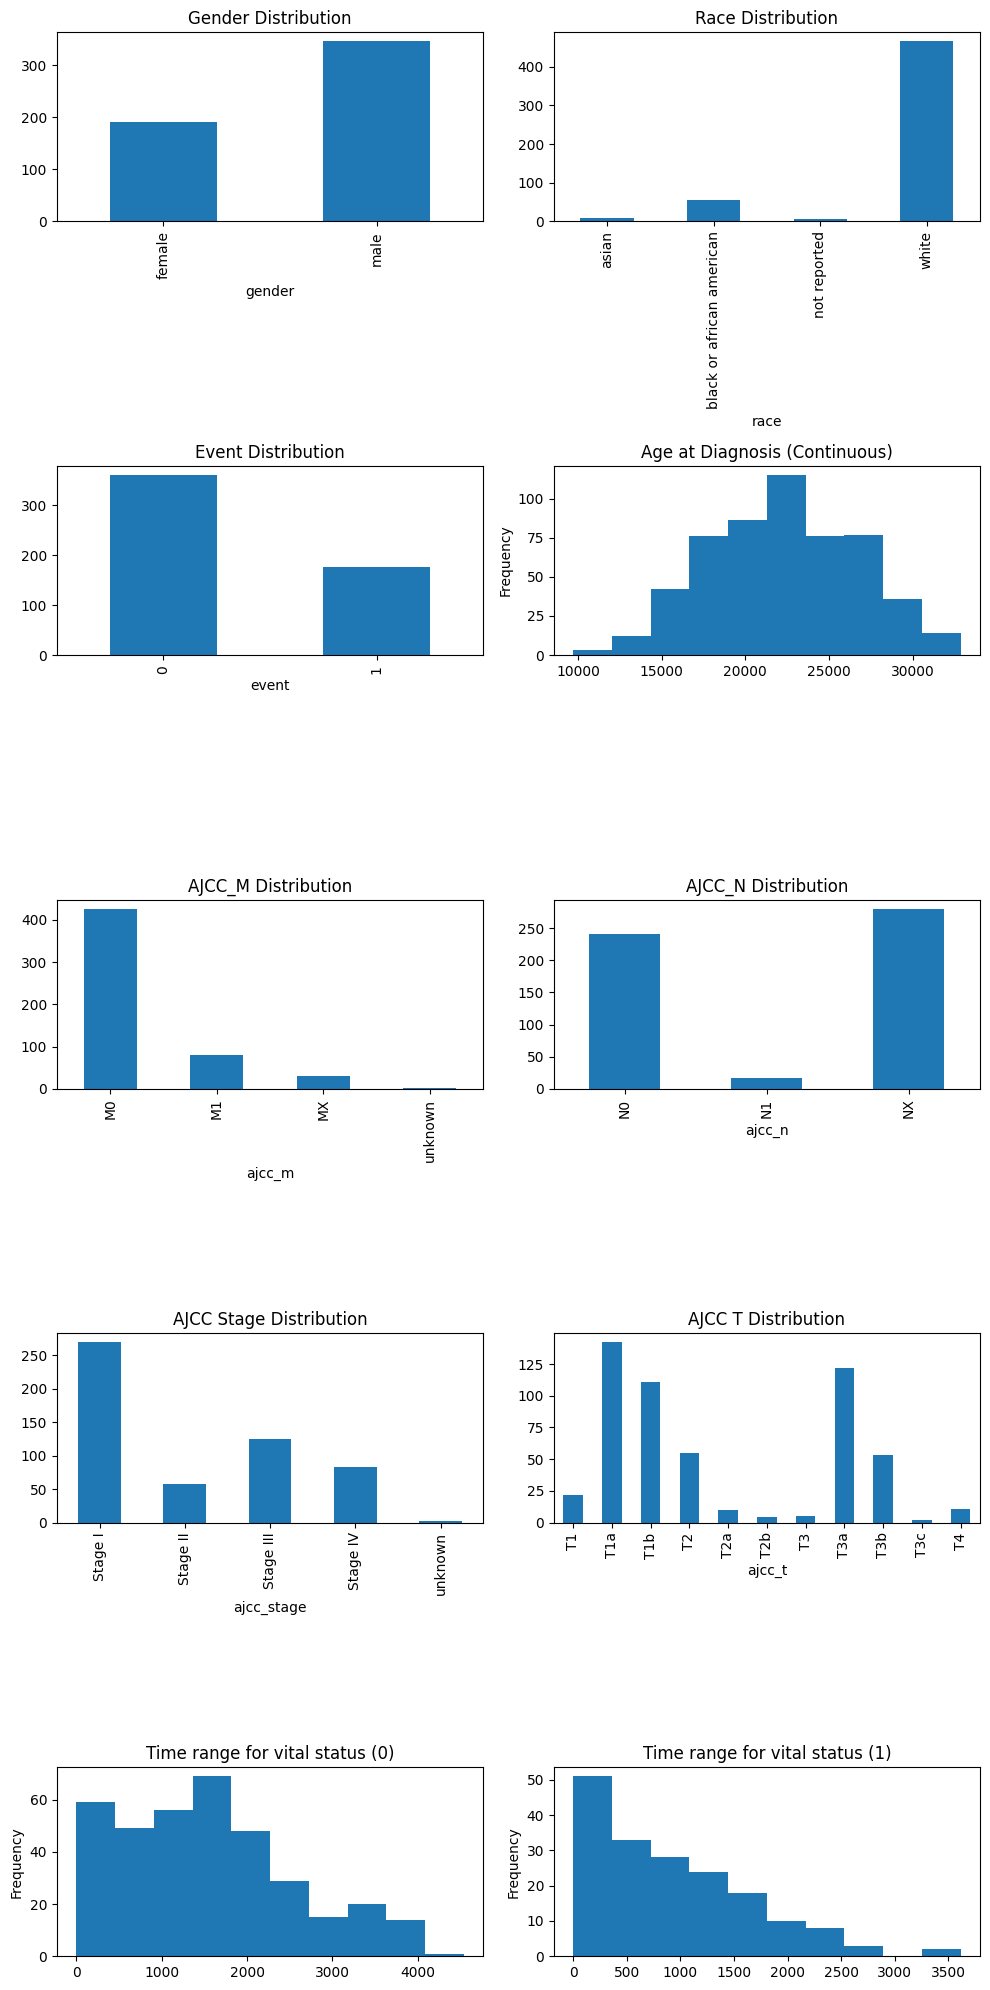

In [169]:
# quick visualization

def visualize(df):
    df['age_diagnosis'] = pd.to_numeric(df['age_diagnosis'], errors='coerce')
    fig, axs = plt.subplots(5, 2, figsize=(10, 20))
    fig.subplots_adjust(hspace=0.5)
    for col, ax in zip(['gender', 'race'], axs[0]):
        df[col].value_counts().sort_index().plot(kind='bar', ax=ax, title=f'{col.capitalize()} Distribution')
    df['event'].value_counts().sort_index().plot(kind='bar', ax=axs[1, 0], title='Event Distribution')
    df['age_diagnosis'].plot(kind='hist', bins=10, ax=axs[1, 1], title='Age at Diagnosis (Continuous)')
    for col, ax in zip(['ajcc_m', 'ajcc_n'], axs[2]):
        df[col].value_counts().sort_index().plot(kind='bar', ax=ax, title=f'{col.upper()} Distribution')
    df['ajcc_stage'].value_counts().sort_index().plot(kind='bar', ax=axs[3, 0], title='AJCC Stage Distribution')
    df['ajcc_t'].value_counts().sort_index().plot(kind='bar', ax=axs[3, 1], title='AJCC T Distribution')
    for event, ax in zip([0, 1], axs[4]):
        df[df['event'] == event]['time'].plot(kind='hist', bins=10, ax=ax, title=f'Time range for vital status ({event})')
    plt.tight_layout()
    plt.show()

visualize(df)

In [176]:
# - label-encode categorical variables

def encode_categorical(df):
    # ordinal
    df = df.copy()
    def ordinal(sorted_values):
        dict_ordinal = {value: i for i, value in enumerate(sorted_values) if value != "unknown"}
        if "unknown" in sorted_values:
            dict_ordinal["unknown"] = -1
        return dict_ordinal
    for col in ["ajcc_m", "ajcc_n", "ajcc_stage", "ajcc_t"]:
        dict_ordinal = ordinal(sorted(df[col].unique()))
        df[col] = df[col].map(dict_ordinal).astype("int8")

    # non-ordinal
    label_encoders = {
        'gender': LabelEncoder(),
        'race': LabelEncoder(),
    }
    for col, encoder in label_encoders.items():
        df[col] = encoder.fit_transform(df[col])

    return df

encoded_df = encode_categorical(df)


- Are these variables good enough for clinical data? Look at all available fields for cases text file => yeah
- Is this correct way to derive the time and event variables for the Cox model?

### Check assumption

<lifelines.CoxPHFitter: fitted with 537 total observations, 360 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 537
number of events observed = 177
   partial log-likelihood = -943.65
         time fit was run = 2025-01-28 06:06:24 UTC

---
               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                      
gender        -0.03      0.97      0.16           -0.35            0.29                0.71                1.33
race           0.15      1.16      0.15           -0.15            0.45                0.86                1.57
age_diagnosis  0.00      1.00      0.00            0.00            0.00                1.00                1.00
ajcc_m         0.34      1.40      0.21           -0.08            0.75                0.92                2.12
ajcc_n        -0.09      0.91      0.08           -0.25            0.06                0.78                1.06
ajcc_stage     0.54      1.72      0.15            0.24            0.84                1.27                2.32
ajcc_t        -0.00      1.00      0.05           -0.10            0.10                0.90                1.11

               cmp to     z      p  -log2(p)
covariate                                   
gender           0.00 -0.19   0.85      0.24
race             0.00  0.97   0.33      1.60
age_diagnosis    0.00  4.74 <0.005     18.83
ajcc_m           0.00  1.58   0.11      3.12
ajcc_n           0.00 -1.22   0.22      2.17
ajcc_stage       0.00  3.52 <0.005     11.20
ajcc_t           0.00 -0.04   0.97      0.05
---
Concordance = 0.75
Partial AIC = 1901.30
log-likelihood ratio test = 121.05 on 7 df
-log2(p) of ll-ratio test = 74.20


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.9211)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8467)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2070)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2786)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4494)'>,
  <Axes: xlabel='km-transformed time\n(p=0.9181)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7561)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8463)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5421)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4292)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5096)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4498)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3150)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2851)'>]]

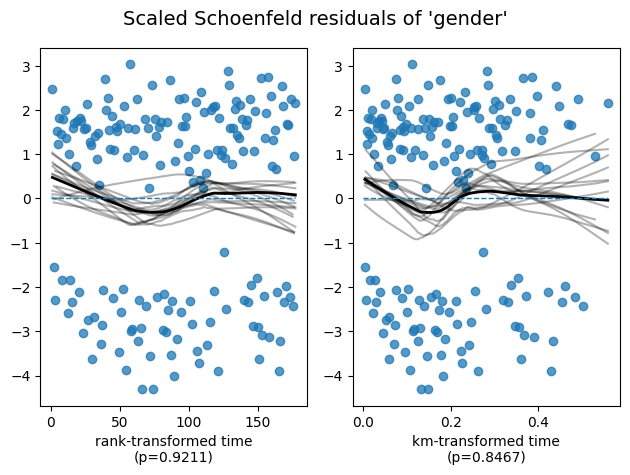

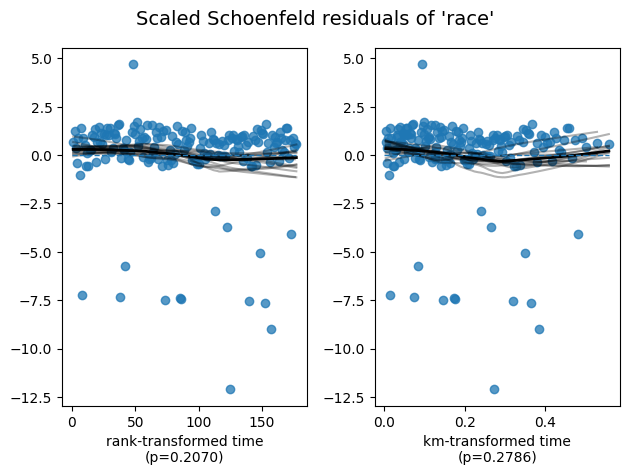

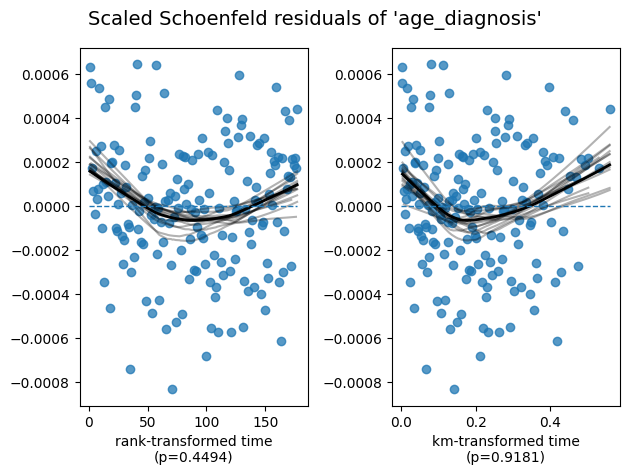

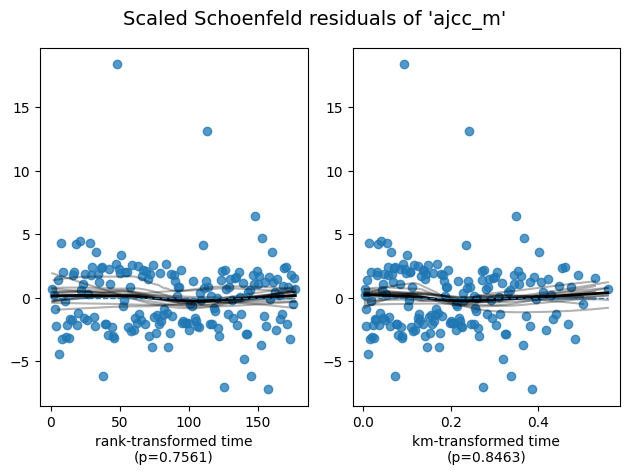

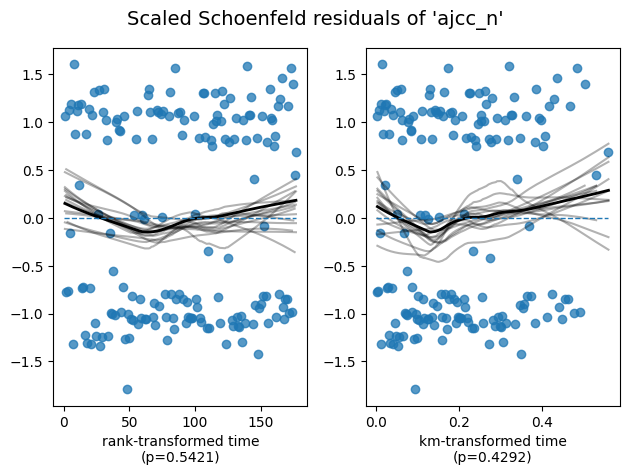

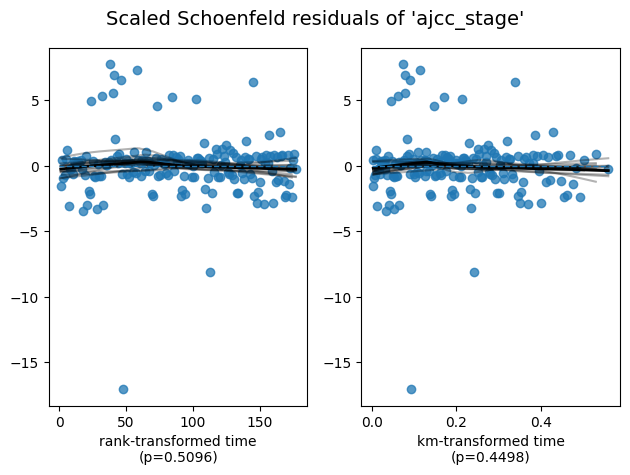

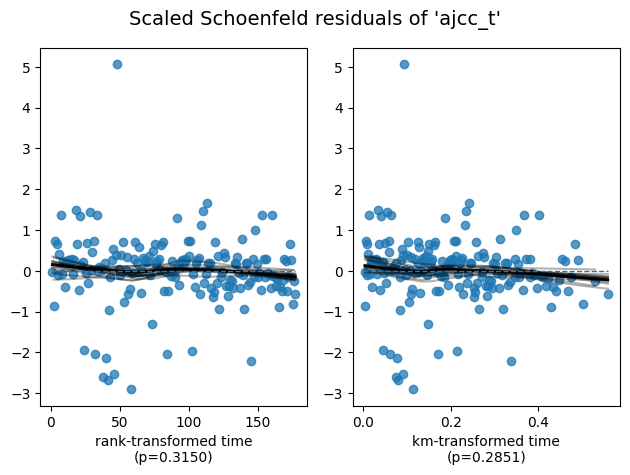

In [183]:
df_check_ph_assumption = encoded_df.drop(["id", "submitter_id"], axis=1)


from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(df_check_ph_assumption, duration_col='time', event_col='event')
cph.print_summary()  

cph.check_assumptions(df_check_ph_assumption, p_value_threshold=0.05, show_plots=True)

# 3. Genomics

Under "files" in "available_fields_for_cases" OR "available_fields_for_files", I'm not sure yet

https://docs.gdc.cancer.gov/API/Users_Guide/Search_and_Retrieval/#post-example

Data Category	Transcriptome Profiling

Data Type	Gene Expression Quantification

Experimental Strategy	RNA-Seq

Platform	Illumina


- gene_id: Unique identifier for each gene (e.g., ENSG numbers).
- gene_name: Gene name for easier interpretation (e.g., TSPAN6, DPM1).
- gene_type: Type of gene (e.g., protein-coding, pseudogene, etc.).
- unstranded/stranded_first/stranded_second: Raw counts of reads mapped to the gene under different library strategies.
- tpm_unstranded: Transcripts Per Million (TPM) – normalized expression value, comparable across genes and samples.
- fpkm_unstranded: Fragments Per Kilobase of transcript per Million mapped reads (FPKM) – normalized for gene length and sequencing depth.
- fpkm_uq_unstranded: Upper Quartile Normalized FPKM – another normalization strategy.

Meaning:
- Focus on tpm_unstranded for relative expression levels, as TPM values are most commonly used for comparison across genes.
- Low or zero expression values (e.g., TNMD with TPM = 0) indicate little or no activity of the gene.
- Compare tpm_unstranded values of genes like FUCA2 (170.7884, high expression) versus CFTR (0.1549, low expression) to determine expression patterns.
- Investigate N_multimapping and N_ambiguous to assess the quality of mapping; high counts here may reduce reliability.
- N_noFeature indicates reads not mapped to annotated features, suggesting incomplete annotation or off-target reads.

Analysis:
- Highly expressed genes: FUCA2 (TPM: 170.7884), DPM1 (TPM: 90.6616), ANKIB1 (TPM: 79.3656). These may be key players in the studied condition.
- Lowly expressed genes: TNMD, CFTR, STPG1, which might not be biologically relevant under these conditions.
- Potentially interesting genes: DPM1 and FUCA2, as they show markedly high expression.


Use TPM values for downstream analysis like clustering or differential expression analysis.
Investigate genes with specific biological or functional relevance to the studied condition (e.g., disease-related genes).
Filter out genes with low or zero expression (e.g., TPM < 1) for cleaner analysis.

In [15]:
rna_seq_count_path = config["datapaths"]["rna_seq_count_path"]

for f in os.listdir(rna_seq_count_path):
    rna_seq_count_file = rna_seq_count_path + f

with open(rna_seq_count_file, "r") as f:

    data = StringIO(f.read())
    df = pd.read_csv(data, sep="\t")

df.head(25)

,,,,,,,,# gene-model: GENCODE v36
gene_id,gene_name,gene_type,unstranded,stranded_first,stranded_second,tpm_unstranded,fpkm_unstranded,fpkm_uq_unstranded
N_unmapped,NaN,NaN,2935707,2935707,2935707,NaN,NaN,NaN
N_multimapping,NaN,NaN,5124862,5124862,5124862,NaN,NaN,NaN
N_noFeature,NaN,NaN,2313888,25894790,26147150,NaN,NaN,NaN
N_ambiguous,NaN,NaN,5050138,1390540,1377049,NaN,NaN,NaN
ENSG00000000003.15,TSPAN6,protein_coding,2370,1234,1137,29.7942,12.1024,13.2261
ENSG00000000005.6,TNMD,protein_coding,0,0,0,0.0000,0.0000,0.0000
ENSG00000000419.13,DPM1,protein_coding,1919,964,955,90.6616,36.8267,40.2462
ENSG00000000457.14,SCYL3,protein_coding,624,883,910,5.1697,2.0999,2.2949
ENSG00000000460.17,C1orf112,protein_coding,627,896,912,5.9889,2.4327,2.6586


# 4. WSIs

- How to handle: a WSI svs is about 1 gb
- Might be using `slide_id` or something under "files" fields

Goals:
- Extracts features from histological images of tissue (e.g., morphology, texture).
- Encodes spatial and structural patterns that might indicate disease severity or progression.

In [105]:
# Function to query the GDC API for slide files associated with a submitter_id
def query_gdc_api(submitter_id):
    files_endpt = "https://api.gdc.cancer.gov/files"
    filters = {
        "op": "and",
        "content": [
            {
                "op": "in",
                "content": {
                    "field": "cases.submitter_id",
                    "value": [submitter_id]
                }
            },
            {
                "op": "in",
                "content": {
                    "field": "files.data_format",
                    "value": ["SVS"]
                }
            }
        ]
    }
    params = {
        "filters": json.dumps(filters),
        "fields": "file_id,file_name",
        "format": "JSON",
        "size": "100"
    }
    response = requests.get(files_endpt, params=params)
    if response.status_code == 200:
        return response.json()["data"]["hits"]
    else:
        print(f"Error querying GDC API: {response.status_code}")
        return []

# Function to download a file from the GDC API using its file_id
def download_slide(file_id, file_name, download_dir):
    data_endpt = f"https://api.gdc.cancer.gov/data/{file_id}"
    response = requests.get(data_endpt, stream=True)
    if response.status_code == 200:
        file_path = os.path.join(download_dir, file_name)
        with open(file_path, "wb") as output_file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    output_file.write(chunk)
        print(f"Downloaded {file_name}")
    else:
        print(f"Error downloading {file_name}: {response.status_code}")

# Main function to execute the download process
def main(submitter_id, download_dir, num_slides=2):
    # Ensure the download directory exists
    os.makedirs(download_dir, exist_ok=True)

    # Query the GDC API for slide files
    slides = query_gdc_api(submitter_id)

    if not slides:
        print("No slides found for the given submitter_id.")
        return

    # Randomly select the specified number of slides
    selected_slides = random.sample(slides, min(num_slides, len(slides)))

    # Download each selected slide
    for slide in selected_slides:
        download_slide(slide["file_id"], slide["file_name"], download_dir)

if __name__ == "__main__":
    download_dir = "./"  # Replace with your desired download directory
    main(config["examples"]["subject_1"], download_dir)


Downloaded TCGA-B8-A54E-01Z-00-DX1.336165F7-BBAC-4FA8-B776-E12483C60B62.svs
Downloaded TCGA-B8-A54E-01A-01-TS1.287E393E-BE65-46F4-BB17-171DC9E825B1.svs


Available levels and their dimensions: ((91392, 21773), (22848, 5443), (5712, 1360), (2856, 680))
Image dimensions at level 0: (91392, 21773)


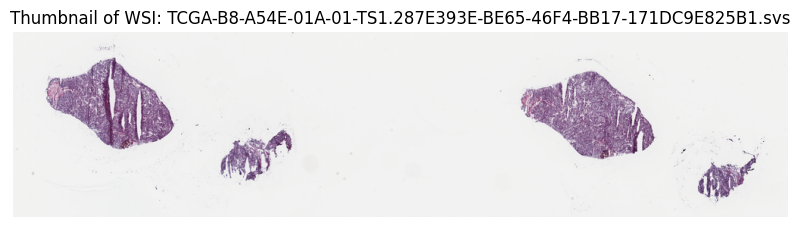

Available levels and their dimensions: ((185639, 68935), (46409, 17233), (11602, 4308), (2900, 1077))
Image dimensions at level 0: (185639, 68935)


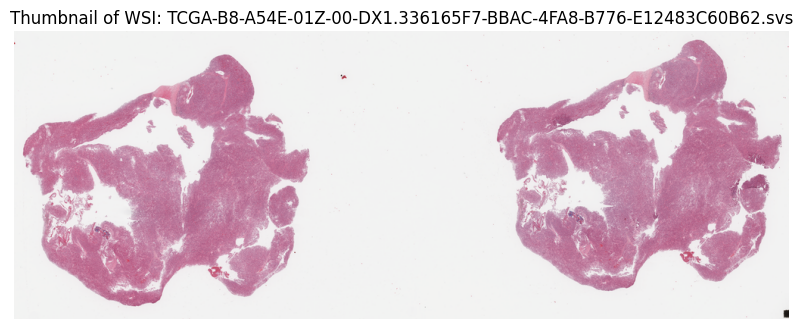

In [128]:

level = 0

file_path_1 = r"D:/data/wsi_slides/TCGA-B8-A54E-01A-01-TS1.287E393E-BE65-46F4-BB17-171DC9E825B1.svs"
file_path_2 = r"D:/data/wsi_slides/TCGA-B8-A54E-01Z-00-DX1.336165F7-BBAC-4FA8-B776-E12483C60B62.svs"


for file_path in [file_path_1, file_path_2]:
    try:
        # Open the SVS file
        slide = openslide.OpenSlide(file_path)

        # Get all level dimensions
        levels = slide.level_dimensions
        print(f"Available levels and their dimensions: {levels}")

        # Ensure the requested level is valid
        if level >= len(levels):
            raise ValueError(f"Level {level} is not valid. Available levels: {len(levels)}.")

        # Get the dimensions of the specified level
        dimensions = levels[level]
        print(f"Image dimensions at level {level}: {dimensions}")

        # Generate a thumbnail for easier visualization if the level is too large
        if dimensions[0] > 20000 or dimensions[1] > 20000:  # Arbitrary threshold
            thumbnail = slide.get_thumbnail((1024, 1024))  # Resize to 1024x1024
            plt.figure(figsize=(10, 10))
            plt.imshow(thumbnail)
            plt.axis("off")
            plt.title(f"Thumbnail of WSI: {file_path.split('/')[-1]}")
            plt.show()
        else:
            # Read the region of interest at the specified level
            region = slide.read_region((0, 0), level, dimensions)

            # Display the extracted region
            plt.figure(figsize=(10, 10))
            plt.imshow(region)
            plt.axis("off")
            plt.title(f"WSI: {file_path.split('/')[-1]} (Level {level})")
            plt.show()

    except Exception as e:
        print(f"Error displaying WSI: {e}")



In [124]:
for i, k in slide.properties.items():
    print(i, k)


aperio.AppMag 40
aperio.DSR ID 152.19.62.167
aperio.Date 11/19/12
aperio.DisplayColor 0
aperio.Exposure Scale 0.000001
aperio.Exposure Time 109
aperio.Filename 11-1041-2
aperio.Focus Offset 0.000000
aperio.ICC Profile ScanScope v1
aperio.ImageID 311102
aperio.Left 18.174372
aperio.LineAreaXOffset 0.014212
aperio.LineAreaYOffset -0.004733
aperio.LineCameraSkew 0.001417
aperio.MPP 0.2472
aperio.OriginalHeight 69035
aperio.OriginalWidth 193440
aperio.ScanScope ID SS1475
aperio.StripeWidth 992
aperio.Time 19:41:42
aperio.Time Zone GMT-05:00
aperio.Title Mag = 40X, compression quality =30
aperio.Top 21.537785
aperio.User 8ce982e3-6ea2-4715-8af3-9874e823e6d9
openslide.associated.thumbnail.height 380
openslide.associated.thumbnail.width 1024
openslide.comment Aperio Image Library vFS90 01
193440x69035 [0,100 185639x68935] (256x256) JPEG/RGB Q=30|AppMag = 40|StripeWidth = 992|ScanScope ID = SS1475|Filename = 11-1041-2|Title = Mag = 40X, compression quality =30|Date = 11/19/12|Time = 19:41:42|T

# Metadata - 267

In [3]:
ct = pd.read_csv(r"D:\data\ct_scans\series-data1738186422626.csv")
ct_patients = ct["Subject ID"].unique()
al = pd.read_csv(r"D:\data\clinical\cleaned_clinical.csv")
al["has_ct"] = al["submitter_id"].apply(lambda x: 1 if x in ct_patients else 0)
print(al["has_ct"].sum(), "patients")
al = al[al["has_ct"]==1]
al["event"].value_counts()

267 patients


event
0    182
1     85
Name: count, dtype: int64

In [16]:
al_267 = al[al["submitter_id"].isin(ct_patients)]
al_267.to_csv(config["clinical_path"]["cleaned_clinical_267"])